# Preprocessing

In [1]:
import os
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sn
warnings.filterwarnings('ignore')

##### Import data + artiste_note ###

In [2]:
#Import Data (all data) and data_by_artist
dfData=pd.read_csv("data.csv")
dataArtist=pd.read_csv("data_by_artist.csv",)
dataArtist=dataArtist[["artists","popularity"]]
#Merge artists with data
dfData["artists"]=dfData["artists"].str.replace("[","").str.replace("]","").str.replace("'",'').str.split(",")
dfData=dfData.explode("artists")
df=pd.merge(dfData,dataArtist,left_on="artists",right_on="artists")
df=df.rename(columns={"popularity_x":"popularity","popularity_y":"artistPop"})
df=df.drop_duplicates(subset=['id'])
data = df

##### Add a new column top 100 hits ### 

In [3]:
# DataSet des Top Hit (jusqu'à 2017)
top_songs = pd.read_csv("top_data.csv", encoding="iso-8859-1")

# On filtre donc notre DataSet de départ pour conserver seuelement les musiques avec date > 2017
data_2017 = data[data["year"]<2017]

# On recherche l'existence des musiques dans le DataSet des Hit Songs pour créer une nouvelle variable de succès 
data_2017["top"] = data_2017["name"].isin(top_songs["title"])
df=data_2017

##### Add a note for song names

In [4]:
name_good=pd.read_csv("name_grade.csv")
del name_good["Unnamed: 0"]
# df=df.rename(columns={"name_good_x":"popularity","name_good_y":"artistPop"})
df=pd.merge(df, name_good, how='inner', on=['name'])
df=df.drop_duplicates(subset=['id'])

##### Take only last n years of a dataFrame from a year

In [5]:
def split_df_by_year(df, range_max, year):
    """
        df : dataframe d'entrée
        step : range maximum d'annees que l'on veut pout notre dataset
        year : annnee de sortie de la musique à preédire
        Renvoie le dataframe respectant le range_max et l'annee
    """

    mask = (df['year'] <= year) & (df['year'] > year - range_max)
    current_df = df.loc[mask]
                
    return current_df
         
df = split_df_by_year(df, 5, 2015)

##### Creating train/test datasets

In [6]:
df.rename(columns={'energy':'Energy',"danceability":"Danceability","loudness":"Loudness(dB)","acousticness":"Acousticness",},inplace=True)

#oversampling 
# print('Original data shape %s' % Counter(y_train))
# sm = SMOTE()
# x_train, y_train = sm.fit_resample(x_train, y_train)
# print('Resampled data shape %s' % Counter(y_train))

#undersampling
# rus = RandomUnderSampler()
# print('Original data shape %s' % Counter(y_train))
# x_train, y_train = rus.fit_sample(x_train, y_train)
# print('Resampled data shape %s' % Counter(y_train))

## Apply a model now

In [7]:
df

,Acousticness,artists,Danceability,duration_ms,Energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,artistPop,top,name_good
5429,0.991000,Frédéric Chopin,0.314,199773,0.01570,0,1lOVilzLQuYY2fnFrQ76DK,0.91600,1,0.1340,...,"Waltz in C-Sharp Minor, Op. 64 No. 2",58,2012-09-14,0.0356,95.890,0.0939,2012,5.251931,False,1.000000
6139,0.992000,Frédéric Chopin,0.309,232240,0.04720,0,6qUjY7JsuQYxn99qfOAQyB,0.86600,3,0.0979,...,"Nocturne in E-Flat Major, Op. 9, No.2",54,2011-02-01,0.0410,72.915,0.0693,2011,5.251931,False,1.000000
7152,0.991000,Frédéric Chopin,0.334,241987,0.00732,0,64LTn5fTsPR0QLy7bVYl9w,0.95200,4,0.0968,...,"Nocturne No. 19 in E Minor, Op. 72, No. 1",59,2011-01-01,0.0355,60.171,0.0964,2011,5.251931,False,1.000000
7436,0.919000,Felix Mendelssohn,0.287,727787,0.14500,0,4Ivo07fh9EyPtPinrxXlC4,0.14400,4,0.0987,...,"Violin Concerto in E Minor, Op. 64, MWV O 14: ...",50,2011-01-01,0.0406,101.679,0.1670,2011,4.964286,False,1.000000
7559,0.993000,Franz Liszt,0.341,357747,0.01420,0,3GecLjGMqzjmgkvy2v41Wf,0.92100,2,0.1130,...,"Ständchen in D Minor (After Schubert), S. 560",55,2011-08-23,0.0388,76.382,0.0384,2011,11.911765,False,0.999710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341872,0.079600,Dawin,0.866,210893,0.73100,0,0mxoXsr14ILAYcXZBMJcOs,0.00000,6,0.0402,...,Dessert,57,2015-09-25,0.0407,97.030,0.7650,2015,57.000000,True,0.360520
341873,0.182000,Hot Flash Heat Wave,0.519,224714,0.80900,0,1sEzuZNasuG8s1OOHwYfN2,0.51000,1,0.0951,...,Gutter Girl,57,2015-09-11,0.0646,111.986,0.2840,2015,57.000000,False,0.823421
341874,0.076100,Jetta,0.459,189973,0.79600,0,6ce17pZwsMcYNab5IaC5MQ,0.00908,4,0.0633,...,I'd Love To Change The World - Matstubs Remix,66,2015-12-18,0.1320,139.913,0.2180,2015,66.000000,False,0.995065
341875,0.000559,It Looks Sad.,0.519,240640,0.72400,0,4GV9tK5QPaD3gVSJvMxUN0,0.00037,4,0.1200,...,Creature,56,2015-06-26,0.0303,135.051,0.4670,2015,56.000000,False,0.871221


In [8]:
# Create a function to encode the data
def one_encode_data(df,ctg_dict):
    # Work on a copy
    df_ = df.copy()
 
    # Encode categorical variable
    #scroll the ctg dict and get all categorical columns and thier possible values
    for k in ctg_dict:
        
        df_[k] = pd.Categorical(df_[k],
                               # Pandas categorical data type
                               # List possible values
                               categories=list(ctg_dict[k]))
    # Encode categorical variables
    return pd.get_dummies(df_)

In [9]:
def compute_metrics_(clf,test_set, true_v, rate):
    y_score = model_.predict_proba(test_set)
    y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
    tn, fp, fn, tp = confusion_matrix(true_v,y_pred_).ravel()
    Arcy=(tp+tn)/(tn+fp+fn+tp)
    Snsity_Rcll=tp / (tp+fn)
    n_mtrc = tn /(tn+fn)
    Spcty = tn / (tn + fp)
    Prcs = tp / (tp + fp)
    F1_Score = 2 * (Prcs * Snsity_Rcll) / (Prcs + Snsity_Rcll)
    n_cmb_mtrc= 2 * (n_mtrc * Snsity_Rcll) / (n_mtrc + Snsity_Rcll)
    return Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc

In [10]:
def compute_metrics_dict(clf,test_set, true_v):
    y_pred=clf.predict(test_set)
    tn, fp, fn, tp = confusion_matrix(true_v,y_pred,labels=[0,1]).ravel()
    Arcy=(tp+tn)/(tn+fp+fn+tp)
    Snsity_Rcll=tp / (tp+fn)
    n_mtrc = tn /(tn+fn)
    Spcty = tn / (tn + fp)
    Prcs = tp / (tp + fp)
    F1_Score = 2 * (Prcs * Snsity_Rcll) / (Prcs + Snsity_Rcll)
    n_cmb_mtrc= 2 * (n_mtrc * Snsity_Rcll) / (n_mtrc + Snsity_Rcll)
    y_score = clf.predict_proba(test_set)
    fpr, tpr, _ = roc_curve(true_v, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    return {'Accuracy':Arcy, 'Sensitivity_Recall':Snsity_Rcll, 'new_metric':n_mtrc, 'Specificity':Spcty, 'Precision':Prcs, 
            'F1_Score':F1_Score, 'new_cmb_score':n_cmb_mtrc,'AUC':roc_auc, 'model':clf}

In [11]:
df.columns

Index(['Acousticness', 'artists', 'Danceability', 'duration_ms', 'Energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'Loudness(dB)',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'artistPop', 'top', 'name_good'],
      dtype='object')

In [12]:
target_df=df['top'].value_counts()
target_df_=pd.DataFrame(target_df)
target_df_["ratio"]=target_df_['top']*100/sum(target_df_['top'])
target_df_

,top,ratio
False,7349,74.69255
True,2490,25.30745


In [13]:
# Used variables for training 
Selected_var=['Acousticness', 'Danceability', 'duration_ms', 'Energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'Loudness(dB)',
       'mode', 'speechiness', 'tempo',
       'valence', 'year', 'artistPop', 'top', 'name_good']

In [14]:
df_sel = df[Selected_var]

In [15]:
ctg_names=["year","key"]

In [16]:
# convert object and int to categirical values for the specified columns name
#compute how many unique value on total
unique_ctg=[]
ctg_dict={}
for c in ctg_names:
    uniqu_c=list(df_sel[c].unique())
    ctg_dict[c]=list(df_sel[c].unique())
    unique_ctg=unique_ctg+uniqu_c

print("Total unique value is",len(unique_ctg))

Total unique value is 17


In [17]:
df_dum=one_encode_data(df_sel,ctg_dict) #attention modif de encode_data par one_encode_data

In [18]:
df_dum.head()

,Acousticness,Danceability,duration_ms,Energy,explicit,instrumentalness,liveness,Loudness(dB),mode,speechiness,...,key_6,key_11,key_7,key_5,key_9,year_2012,year_2011,year_2015,year_2013,year_2014
5429,0.991,0.314,199773,0.01570,0,0.916,0.1340,-36.252,0,0.0356,...,0,0,0,0,0,1,0,0,0,0
6139,0.992,0.309,232240,0.04720,0,0.866,0.0979,-25.497,1,0.0410,...,0,0,0,0,0,0,1,0,0,0
7152,0.991,0.334,241987,0.00732,0,0.952,0.0968,-30.908,0,0.0355,...,0,0,0,0,0,0,1,0,0,0
7436,0.919,0.287,727787,0.14500,0,0.144,0.0987,-19.665,0,0.0406,...,0,0,0,0,0,0,1,0,0,0
7559,0.993,0.341,357747,0.01420,0,0.921,0.1130,-28.293,1,0.0388,...,0,0,0,0,0,0,1,0,0,0


In [19]:
top_values=df_dum['top'].values

In [20]:
df_dum=df_dum.drop(['top'], axis=1)

In [21]:
df_dum.columns

Index(['Acousticness', 'Danceability', 'duration_ms', 'Energy', 'explicit',
       'instrumentalness', 'liveness', 'Loudness(dB)', 'mode', 'speechiness',
       'tempo', 'valence', 'artistPop', 'name_good', 'key_1', 'key_3', 'key_4',
       'key_2', 'key_8', 'key_0', 'key_10', 'key_6', 'key_11', 'key_7',
       'key_5', 'key_9', 'year_2012', 'year_2011', 'year_2015', 'year_2013',
       'year_2014'],
      dtype='object')

In [22]:
dataset=df_dum.values

In [23]:
scaler = preprocessing.StandardScaler()
dataset_s=scaler.fit_transform(dataset)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataset_s, top_values, test_size=0.33)

In [25]:
Models_predictions=pd.DataFrame()
Models_predictions['y_ref']=y_test

## MLP classifier

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
clf_MLP = MLPClassifier(random_state=1,hidden_layer_sizes=200, max_iter=1200)
clf_MLP.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=200, max_iter=1200, random_state=1)

Accuracy: 0.73
Sensitivity: 0.47
new_metric: 0.82
Specificity: 0.83
Precision: 0.49
f_1 Score: 0.48


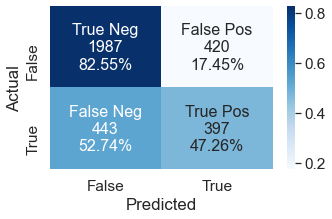

In [28]:
model_=clf_MLP
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

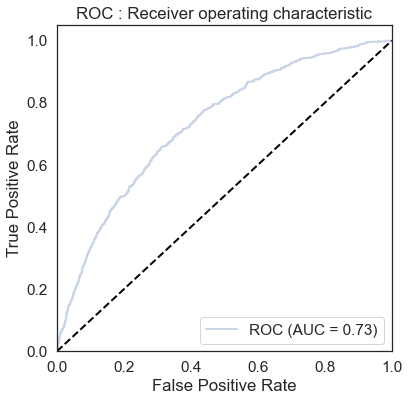

In [29]:
sn.set_style('white')
fig_auc, ax_auc = plt.subplots(1, 1, figsize=(6, 6))

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
ax_auc.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC (AUC = %0.2f)' % roc_auc)

ax_auc.plot([0,1],[0,1], linestyle='--', lw=2, color='black')
ax_auc.set_xlim([0.0, 1.0])
ax_auc.set_ylim([0.0, 1.05])
ax_auc.set_xlabel('False Positive Rate')
ax_auc.set_ylabel('True Positive Rate')
plt.title('ROC : Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
#Grid parameters
from sklearn.model_selection import ParameterGrid
import numpy as np
hidden_layer_sizes=[int(i) for i in np.linspace(1,500,3)]
activation=["identity", "logistic", "tanh", "relu"]
#activation=["relu"]
solver=["adam",'sgd','adam']
#alpha=np.linspace(0.00001,0.0001,4)

grid_dict={'hidden_layer_sizes':hidden_layer_sizes,'activation':activation,'solver':solver}
#MLP_Grids=
MLP_Grids=ParameterGrid(grid_dict)
print(len(MLP_Grids))

36


In [31]:
#Grid parameters
from sklearn.model_selection import ParameterGrid
hidden_layer_sizes=[int(i) for i in np.linspace(200,400,10)]
activation=["logistic"]
solver=['sgd']
#alpha=np.linspace(0.00001,0.0001,4)

grid_dict={'hidden_layer_sizes':hidden_layer_sizes,'activation':activation,'solver':solver}
#MLP_Grids=
MLP_Grids=ParameterGrid(grid_dict)
print(len(MLP_Grids))
# activation='logistic', hidden_layer_sizes=250, max_iter=1200,
#               solver='sgd'

10


In [32]:
model_.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 200,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

##### MLP - Hyper param tuning

In [33]:
from tqdm import tqdm
#progress bar 
model_list=[]
score_list=[]
# df for metrics souvgarde
df_merics_tune = pd.DataFrame(columns = ['Accuracy', 'Sensitivity_Recall', 'new_metric',
                                    'Specificity','Precision','F1_Score','new_cmb_score','AUC','model'])
for param in tqdm(list(MLP_Grids)):
    clf_MLP = MLPClassifier(max_iter=1200,random_state=1,**param)
    clf_MLP.fit(X_train, y_train)
    #model_list.append(clf_MLP)
    metrcis_dic_=compute_metrics_dict(clf_MLP, X_test, y_test)
#     print(clf_MLP.get_params())
    # append rows to an empty DataFrame
    df_merics_tune = df_merics_tune.append(metrcis_dic_,ignore_index = True)
    #score_list.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.29s/it]


In [34]:
df_merics_tune.iloc[2]

Accuracy                                                       0.766862
Sensitivity_Recall                                             0.244048
new_metric                                                     0.782534
Specificity                                                    0.949314
Precision                                                      0.626911
F1_Score                                                       0.351328
new_cmb_score                                                  0.372061
AUC                                                            0.762088
model                 MLPClassifier(activation='logistic', hidden_la...
Name: 2, dtype: object

## Best MLP model

In [35]:
clf_MLP = MLPClassifier(random_state=1,hidden_layer_sizes=244, max_iter=1200,activation='logistic', solver='sgd')
clf_MLP.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=244, max_iter=1200,
              random_state=1, solver='sgd')

Accuracy: 0.77
Sensitivity: 0.24
new_metric: 0.78
Specificity: 0.95
Precision: 0.63
f_1 Score: 0.35


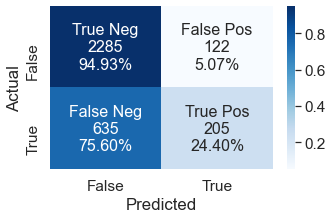

In [36]:
model_=clf_MLP
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [37]:
#save models prediction data
Models_predictions['Y_pred_MLP']=y_pred_
Models_predictions['Y_score_MLP']=y_score[:, 1]

## Stochastic Gradient Descent

In [38]:
from sklearn.linear_model import SGDClassifier

In [39]:
clf_SGDC =SGDClassifier(max_iter=1000, loss='log')

In [40]:
clf_SGDC.fit(X_train, y_train)

SGDClassifier(loss='log')

Accuracy: 0.76
Sensitivity: 0.24
new_metric: 0.78
Specificity: 0.94
Precision: 0.6
f_1 Score: 0.34


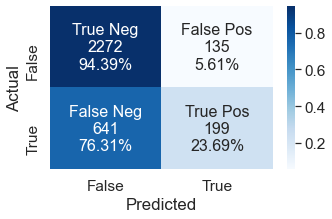

In [41]:
model_=clf_SGDC
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [42]:
#save models prediction data
Models_predictions['Y_pred_SGD']=y_pred_
Models_predictions['Y_score_SGD']=y_score[:, 1]

## XGB

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

In [44]:
XGB = GradientBoostingClassifier(random_state=0)
# fit the model, 
XGB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

Accuracy: 0.77
Sensitivity: 0.33
new_metric: 0.8
Specificity: 0.93
Precision: 0.62
f_1 Score: 0.43


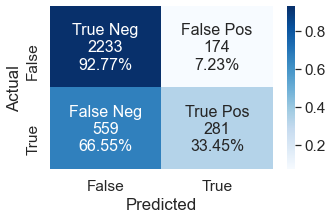

In [45]:
model_=XGB
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [46]:
Models_predictions['Y_pred_XGB']=y_pred_
Models_predictions['Y_score_XGB']=y_score[:, 1]

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

Accuracy: 0.77
Sensitivity: 0.26
new_metric: 0.79
Specificity: 0.94
Precision: 0.61
f_1 Score: 0.37


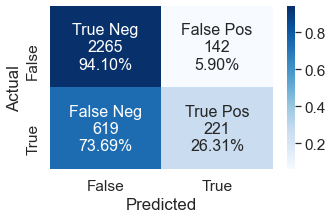

In [48]:
model_=clf_LR
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [49]:
Models_predictions['Y_pred_LR']=y_pred_
Models_predictions['Y_score_LR']=y_score[:, 1]

## KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_score = model_.predict_proba(X_test)

Accuracy: 0.72
Sensitivity: 0.35
new_metric: 0.79
Specificity: 0.85
Precision: 0.45
f_1 Score: 0.39


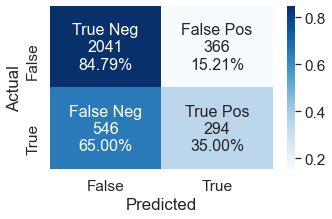

In [60]:
model_=neigh
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [61]:
#save models prediction data
Models_predictions['Y_pred_KNN']=y_pred_
Models_predictions['Y_score_KNN']=y_score[:, 1]

# Naive Bayes

In [52]:
import pandas as pd
from math import exp,sqrt,pi
from pycm import ConfusionMatrix

""" Naive Bayes Classifier : Class"""
class Bayes: 
    #def __init__(self,data,labelColumn,predictors,ratio,year):
#         self.data=data
#         self.data.instrumentalness=self.data.instrumentalness*100
#         self.data=self.data[(self.data.year>year-1) & (self.data.year<=year+1)].reset_index()
        
#         boundary=int(self.data.shape[0]*ratio)
#         self.train=self.data[:boundary]
#         one=self.train[self.train.top==True].index.values.tolist()
#         zero=self.train[self.train.top==False].index.values.tolist()
        
#         #print("print",len(one)*(1.25/1.75))

#         indices=zero[:375] +one[:125] #75% de zero and 25% de one, avec un tout limité à 500

#         self.train=self.train.iloc[indices].reset_index()
        
#         self.test=self.data[boundary:].reset_index()
        
#         self.labelColumn=labelColumn
#         self.labels=list(set(self.test[labelColumn].values.tolist()))
#         self.predictors=predictors
    
    def __init__(self,dataTrain,dataTest,labelColumn,preditors):
        self.train=dataTrain
        self.test=dataTest
        self.labelColumn=labelColumn
        self.labels=list(set(self.test[labelColumn].values.tolist()))
        self.predictors=predictors
    """ 
        Compute the probability of each class
        P(True) & P(False)
    """
    def ProbaLabel(self):
        total=self.train.shape[0]
        count=[]
        for label in self.labels:
            byLabel=self.train[self.train[self.labelColumn]==label]
            count.append(byLabel.shape[0]/total)
        return count
    
    """
        Compute the mean & standard deviation for each predictor given a certain class
        ex : P('accousticness'|True)
    """
    def RawConditionnelle(self):
        res=[]
        #gaussian=exp(-((x-mean)**2 / (2 * stdev**2 )))
        for label in self.labels:
            temp=[]
            byLabel=self.train[self.train[self.labelColumn]==label]
            for predictor in self.predictors:
                serie=byLabel[predictor]
                temp.append((serie.mean(),serie.std(),serie.shape[0]))
            res.append(temp)
        return res
    
    """ Compute the Gaussian Function for probability"""
    def ComputeGaussian(self,x,mean,std):
        exponent = exp(-((x-mean)**2 / (2 * std**2 )))
        return (1 / (sqrt(2 * pi) * std)) * exponent
    
    """Compute the probability of an ind of belonging to the different class """
    def GaussianProba(self,x):
        raw=self.RawConditionnelle()
        probaLabel=self.ProbaLabel()
        proba={}
        for i,label in enumerate(self.labels):
            data=raw[i]
            proba[label]=probaLabel[i]*10
            for j in range(len(self.predictors)):
                proba[label]*=self.ComputeGaussian(x[j],data[j][0],data[j][1])
        return proba

    def Predict(self,x):
        probabilites = self.GaussianProba(x)
        bestLabel,bestProb=None,-1
        for classValue, prob in probabilites.items():
            if bestLabel is None or prob>bestProb:
                bestProb=prob
                bestLabel=classValue
        return bestLabel,bestProb
    
    def FTNB(self):
        #phase 1: 
        probaLabel=self.ProbaLabel()
        probaConditionelles=self.RawConditionnelle()
        for predictor in self.predictors:
            pass
        pass
    
    def Accuracy(self):
        xTest=self.test[self.predictors].to_numpy()
        yTest=self.test[self.labelColumn].to_numpy()
        yPredict=[]
        yProba=[]
        for x in xTest:
            prediction,proba=self.Predict(x)
            yPredict.append(prediction)
            yProba.append(proba)
        correctPos,correctNeg,uncorrectPos,uncorrectNeg=0,0,0,0
        for i in range(len(yTest)):
            if yTest[i]==yPredict[i] and yPredict[i]==True:
                correctPos+=1
            elif yTest[i]==yPredict[i] and yPredict[i]==False:
                correctNeg+=1
            elif yTest[i]==True and yPredict[i]==False:
                uncorrectNeg+=1
            else: 
                uncorrectPos+=1
        cm = ConfusionMatrix(yTest,yPredict)
#         print(cm.class_stat)
#         print(cm.overall_stat)
#         print('Matrice de confusion :')
#         print(' ','|','PRED  0  ','|','PRED  1 ')
#         print('REEL 0','|',correctNeg/float(len(yTest)),'|',uncorrectNeg/float(len(yTest)))
#         print('REEL 1','|',uncorrectPos/float(len(yTest)),'|',correctPos/float(len(yTest)))
#         print()
#         print('Total Accuracy :', (correctNeg+correctPos)/float(len(yTest)))
        return yPredict,yProba

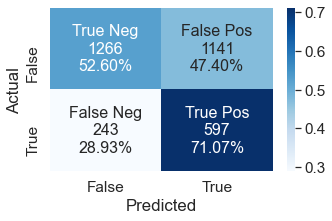

In [53]:


predictors=df_dum.columns.values
dfTrain=pd.DataFrame(data=X_train,columns=predictors)
dfTrain['top']=y_train
dfTest=pd.DataFrame(data=X_test,columns=predictors)
dfTest['top']=y_test

bayes=Bayes(dfTrain,dfTest,'top',predictors)
yPredictNB,yProbaNB=bayes.Accuracy()

cm = confusion_matrix(y_test,yPredictNB)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size



In [54]:
#save model pred for bayes 
Models_predictions['Y_pred_NB']=yPredictNB
Models_predictions['Y_score_NB']=yProbaNB

In [62]:
Models_predictions

,y_ref,Y_pred_MLP,Y_score_MLP,Y_pred_SGD,Y_score_SGD,Y_pred_XGB,Y_score_XGB,Y_pred_LR,Y_score_LR,Y_pred_NB,Y_score_NB,Y_pred_KNN,Y_score_KNN
0,False,0,0.057936,0,0.085897,0,0.021776,0,0.048806,False,1.159723e-20,0,0.000000
1,False,0,0.180575,0,0.083172,0,0.253196,0,0.148150,False,1.190414e-18,0,0.333333
2,True,1,0.716128,1,0.536452,1,0.659795,1,0.747297,True,7.116000e-23,1,0.666667
3,False,0,0.092565,0,0.092180,0,0.018349,0,0.100442,False,1.736399e-19,0,0.000000
4,False,0,0.171773,0,0.080572,0,0.108085,0,0.148441,False,7.654877e-18,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3242,False,0,0.269585,0,0.103958,0,0.435783,0,0.268236,False,5.182241e-20,0,0.000000
3243,True,1,0.725769,1,0.746069,1,0.722752,1,0.730890,True,1.232476e-17,1,1.000000
3244,False,0,0.125049,0,0.086106,0,0.079756,0,0.102365,True,1.231773e-17,0,0.000000
3245,True,0,0.170320,0,0.123785,0,0.317750,0,0.191592,False,6.579926e-18,0,0.000000


In [67]:
# df for metrics souvgarde
df_modeles_merics = pd.DataFrame(columns = ['Accuracy', 'Sensitivity_Recall',
                                    'Specificity','Precision','F1_Score','AUC'])
models_name=["XGB","LR","MLP","SGD","KNN","NB"]
true_v=Models_predictions["y_ref"].values
for m in models_name:
    y_pred_=Models_predictions["Y_pred_"+m].values
    y_score=Models_predictions["Y_score_"+m].values
    tn, fp, fn, tp = confusion_matrix(true_v,y_pred_).ravel()
    Arcy=(tp+tn)/(tn+fp+fn+tp)
    Snsity_Rcll=tp / (tp+fn)
    Spcty = tn / (tn + fp)
    Prcs = tp / (tp + fp)
    F1_Score = 2 * (Prcs * Snsity_Rcll) / (Prcs + Snsity_Rcll)
    fpr, tpr, _ = roc_curve(true_v, y_score)
    roc_auc = auc(fpr, tpr)
    metrics={'Accuracy':Arcy, 'Sensitivity_Recall':Snsity_Rcll, 'Specificity':Spcty, 'Precision':Prcs, 
            'F1_Score':F1_Score,'AUC':roc_auc}
    # append rows to an empty DataFrame 
    df_modeles_merics = df_modeles_merics.append(metrics, ignore_index=True)

#df_modeles_merics.set_index('Model')

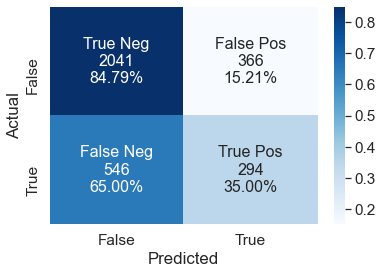

In [68]:
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

In [69]:
pd.options.display.float_format = '{:,.2f}'.format

[Text(0, 0.5, 'XGB'),
 Text(0, 1.5, 'LR'),
 Text(0, 2.5, 'MLP'),
 Text(0, 3.5, 'SGD'),
 Text(0, 4.5, 'KNN'),
 Text(0, 5.5, 'NB')]

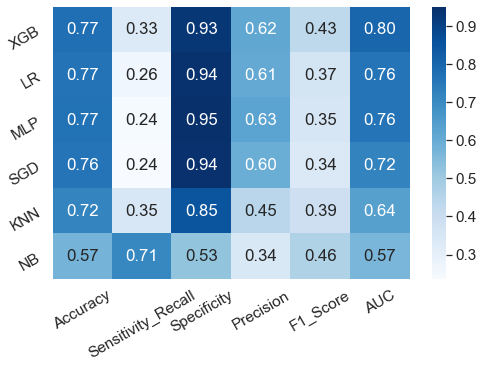

In [70]:
plt.figure(figsize = (8,5))
sn.set(font_scale=1.4) #for label size
heatmap=sn.heatmap(df_modeles_merics, cmap="Blues",annot=True, fmt=".2f",yticklabels=models_name)# font size
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=30) 